In [1]:
import os
import platform
from tkinter import Tk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

import sys
sys.path.insert(0, os.path.abspath('.'))
from tools import Sim_Parameters, Train_Parameters, create_dataset, RMSELoss, train_val_test, test_epoch, simulator, ballsINTObins, load_data, NoisyDataset, simulator

%matplotlib widget

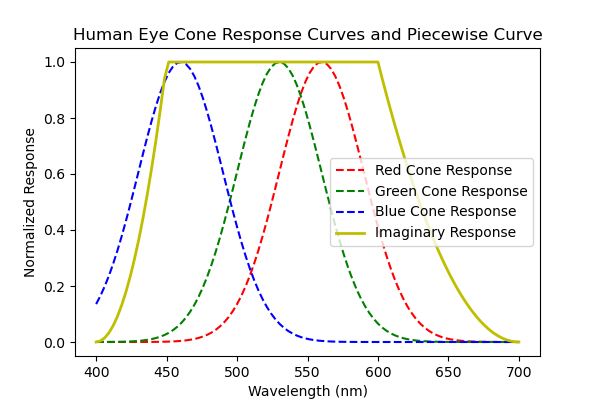

In [2]:
# RGB Cone Demo

import numpy as np
import matplotlib.pyplot as plt

# Define the wavelength range in nanometers
wavelengths = np.linspace(400, 700, 100)  # Range from 400nm (blue) to 700nm (red)

# Cone response curves for the human eye (approximate)
# These values are normalized, and you can adjust them for your specific needs.
# These are just example values.
cone_response_R = np.exp(-(wavelengths - 560) ** 2 / (2 * 30 ** 2))  # Red-sensitive (L-cones)
cone_response_G = np.exp(-(wavelengths - 530) ** 2 / (2 * 30 ** 2))  # Green-sensitive (M-cones)
cone_response_B = np.exp(-(wavelengths - 460) ** 2 / (2 * 30 ** 2))  # Blue-sensitive (S-cones)

# Normalize the response curves
cone_response_R /= np.max(cone_response_R)
cone_response_G /= np.max(cone_response_G)
cone_response_B /= np.max(cone_response_B)

# Define the piecewise function
piecewise_curve = np.piecewise(wavelengths, [wavelengths < 450, (wavelengths >= 450) & (wavelengths <= 600), wavelengths > 600], 
                               [lambda x: ((x - 400) / 50) ** 2, 1, lambda x: ((x - 700) / 100) ** 2])

# Create a plot
plt.figure(figsize=(6, 4))
plt.plot(wavelengths, cone_response_R, 'r--', label='Red Cone Response')
plt.plot(wavelengths, cone_response_G, 'g--', label='Green Cone Response')
plt.plot(wavelengths, cone_response_B, 'b--', label='Blue Cone Response')

# Add the piecewise curve (yellow, thicker, labeled as 'Imaginary Response')
plt.plot(wavelengths, piecewise_curve, 'y', label='Imaginary Response', linewidth=2)

# Customize the plot
plt.title('Human Eye Cone Response Curves and Piecewise Curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()


(100, 2)
Explained Variance Ratios (2D): [0.86883395 0.13116605]
Total Explained Variance (2D): 1.0
Explained Variance Ratios (1D): [0.86883395]
Total Explained Variance (1D): 0.868833946796928


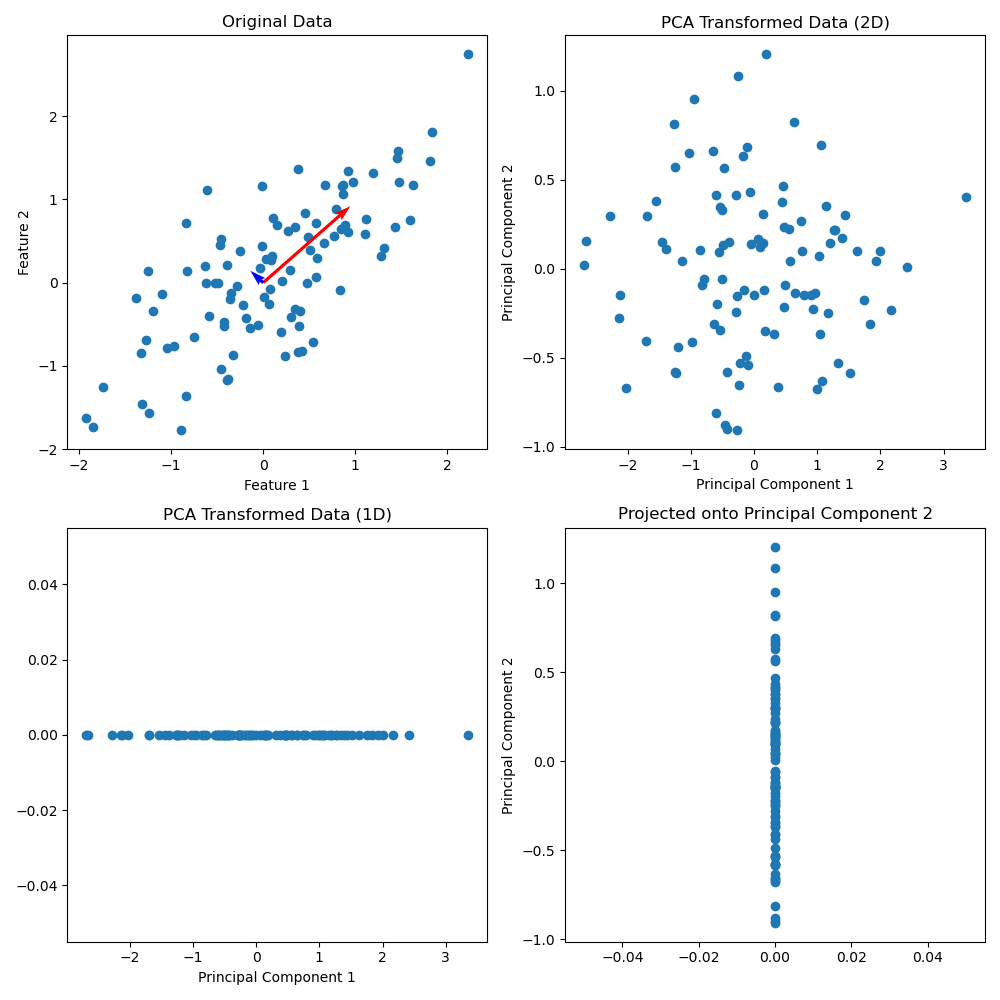

In [3]:
# PCA Demo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create synthetic 2D data
np.random.seed(42)
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]
X = np.random.multivariate_normal(mean, cov, 100)
print(X.shape)

# Initialize PCA with 2 components
pca_2d = PCA(n_components=2)
pca_1d = PCA(n_components=1)

# Fit and transform the data
X_pca_2d = pca_2d.fit_transform(X)
X_pca_1d = pca_1d.fit_transform(X)

# Percentage of variance explained by each component
explained_variance_ratio_2d = pca_2d.explained_variance_ratio_
explained_variance_ratio_1d = pca_1d.explained_variance_ratio_

# Get the eigenvectors and eigenvalues from the PCA model
eigen_vectors = pca_2d.components_
eigen_values = pca_2d.explained_variance_

print("Explained Variance Ratios (2D):", explained_variance_ratio_2d)
print("Total Explained Variance (2D):", np.sum(explained_variance_ratio_2d))
print("Explained Variance Ratios (1D):", explained_variance_ratio_1d)
print("Total Explained Variance (1D):", np.sum(explained_variance_ratio_1d))

# Plot original data, PCA 2D, and PCA 1D
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.quiver(0, 0, eigen_vectors[0, 0] * eigen_values[0], eigen_vectors[0, 1] * eigen_values[0], angles='xy', scale_units='xy', scale=1, color='red', label='Eigenvec. 1')
plt.quiver(0, 0, eigen_vectors[1, 0] * eigen_values[1], eigen_vectors[1, 1] * eigen_values[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Eigenvec. 2')
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(2, 2, 2)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.title("PCA Transformed Data (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.subplot(2, 2, 3)
plt.scatter(X_pca_1d, np.zeros_like(X_pca_1d))
plt.title("PCA Transformed Data (1D)")
plt.xlabel("Principal Component 1")

plt.subplot(2, 2, 4)
plt.scatter(np.zeros_like(X_pca_2d[:, 1]), X_pca_2d[:, 1])
plt.title("Projected onto Principal Component 2")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


In [4]:
# User Input
# substance_ind_list = [6, 11, 13, 14]
# substance_ind_list = [2, 12, 18, 19]
# substance_ind_list = [1, 3, 5, 18]
# substance_ind_list =  [3, 4, 5, 12]
# substance_ind_list = [0, 6, 11, 13]
substance_ind_list =  [6, 7, 8]
# substance_ind_list =  [3, 4, 5]
substance_ind_list = list(range(4))
substance_ind_list.sort()

basis_func_ind_list = [0, 1, 2, 5]
basis_func_ind_list.sort()

# temp_K_list = np.asarray(list(range(-20, 51, 10))) + 273.15
temp_K_list = np.asarray([293.15])
temp_K_list.sort()


air_trans, basis_funcs, spectra, substances_emit = load_data(air_trans_file='./data/Test 3 - 4 White Powers/Air transmittance.xlsx',
                                                             basis_func_file='./data/Test 3 - 4 White Powers/Basis functions_4-20um.xlsx',
                                                             spectra_file='./data/Test 3 - 4 White Powers/white_powders_spectra.xlsx', 
                                                             substances_emit_file='./data/Test 3 - 4 White Powers/white_powders.xlsx',)
                                                            #  substance_names_file='./data/Test 2 - 21 Substances/sequence.xlsx')

substance_names = np.array(pd.read_excel('./data/Test 3 - 4 White Powers/white_powders_names.xlsx', header=None))

# Start

# results = []

b_f_comb = [0, 1, 2, 3, 4, 5, 6]
comb = b_f_comb
temp_K = 293.15

sim_params = Sim_Parameters(air_trans=air_trans,
                            air_RI=1,
                            atm_dist_ratio=0.11,
                            basis_funcs=basis_funcs,
                            basis_func_comb=comb,
                            substance_ind_list=substance_ind_list,
                            spectra=spectra,
                            substances_emit=substances_emit,
                            temp_K=temp_K)

dataset = create_dataset(sim_params)


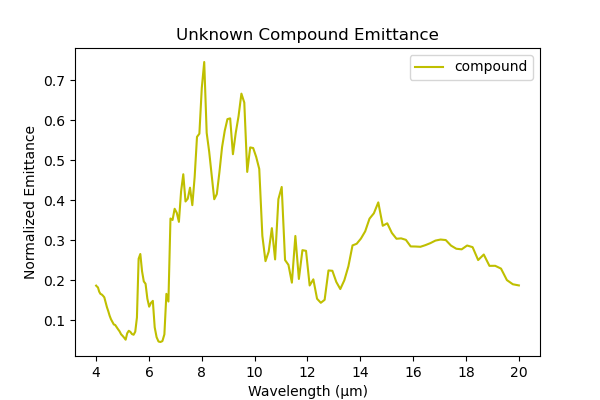

In [5]:
# Plot original emmittance

# Create a single plot
plt.figure(figsize=(6, 4))

# Iterate over the column indices and plot the corresponding columns after applying the simulator()
# for idx in substance_ind_list:
#     # spec = spectra[:, idx]
#     sub_signal = substances_emit[:, idx]
#     print(substance_names[idx, :])
#     plt.plot(spectra, sub_signal, label=substance_names[idx, 1])

plt.plot(spectra, np.matmul(substances_emit, np.asarray([0.2, 0.1, 0.3, 0.4]).transpose()), label='compound', color='y')

plt.xlabel('Wavelength (μm)')
plt.ylabel('Normalized Emittance')
plt.title('Unknown Compound Emittance')
plt.legend()
plt.show()

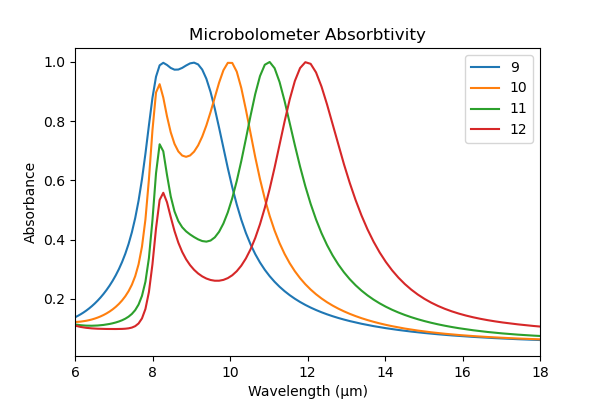

In [8]:
# Plot microbolometer basis functions

basis_func_ind_list = [1, 2, 3, 4]

# Create a single plot
plt.figure(figsize=(6, 4))

# Iterate over the column indices and plot the corresponding columns after applying the simulator()
for idx in basis_func_ind_list:
    # spec = spectra[:, idx]
    # sub_signal = substances_emit[:, idx]
    # print(substance_names[idx, :])
    b_f = basis_funcs[:, idx+1]
    plt.plot(spectra, b_f, label=idx+8)

# plt.subplots_adjust(left=0.2, right=0.5, bottom=0.25)
plt.xlabel('Wavelength (μm)')
plt.ylabel('Absorbance')
plt.title('Microbolometer Absorbtivity')
plt.legend()
plt.xlim(6, 18)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

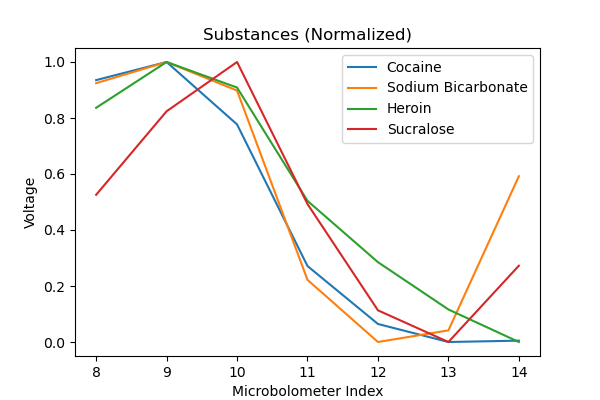

In [5]:
# Assuming you have substances_emit and substance_ind_list available

# Create a single plot
plt.figure(figsize=(6, 4))

# Iterate over the column indices and plot the corresponding columns after applying the simulator()
for idx in substance_ind_list:
    sub_signal = substances_emit[:, idx]
    sub_signal = np.expand_dims(sub_signal, 1)
    
    out = simulator(sim_params, sub_signal)  # Apply simulator() function to the column
    out = (out - np.min(out)) / (np.max(out) - np.min(out))

    plt.plot(np.arange(len(out))+8, out, label=substance_names[idx, 1])  # Plot the output after applying the simulator()

plt.xlabel('Microbolometer Index')
plt.ylabel('Voltage')
plt.title('Substances (Normalized)')
plt.legend()
# plt.ylim(0, 30)
plt.show()


In [6]:
from tools import difference_matrix, emd_matrix

# substance_ind_list = [1, 3, 5, 18]
# substance_ind_list =  [6, 7, 8, 12]
# substance_ind_list =  [0, 6, 11, 13]
# substance_ind_list =  [3, 4, 5, 12]

subs = []
for idx in substance_ind_list:
    column_values = substances_emit[:, idx]
    column_values = np.expand_dims(column_values, 1)
    out = simulator(sim_params, column_values)
    out = (out - np.min(out)) / (np.max(out) - np.min(out))
    subs.append(out)

d_matrix = difference_matrix(subs)
np.savetxt('allsub_d_matrix.csv', d_matrix, delimiter=',')

emd_matrix = emd_matrix(subs)
np.savetxt('allsub_emd_matrix.csv', emd_matrix, delimiter=',')

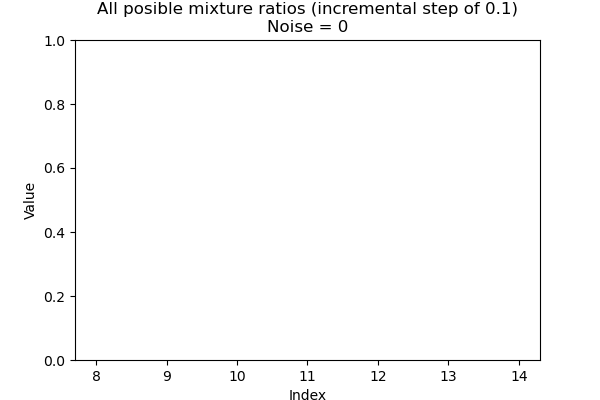

In [7]:
noise_perc = 0

# Assuming you have a PyTorch dataset named 'dataset'

x_values = []
y_values = []

result = []

for idx, data in enumerate(dataset):
    x, y = data  # Assuming each data point in the dataset consists of (x, y) pair
    x_values.append(x)
    y_values.append(y)

    row = np.concatenate((x.numpy(), y.numpy()), axis=0)
    result.append(row)
    # if idx>30:
    #     print("x", x.numpy())
    #     print("y", y.numpy())

result = np.asarray(result)
np.savetxt('temp_data.csv', result, delimiter=',')


import matplotlib.pyplot as plt
import numpy as np


# Create a single plot
plt.figure(figsize=(6, 4))
plt.subplots_adjust(top=0.9, bottom=0.1)

# Iterate over each x value and plot the specified indices
for x in x_values:
    plt.plot(np.arange(len(b_f_comb))+8, x)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('All posible mixture ratios (incremental step of 0.1)\n' + 'Noise = ' + str(noise_perc))
# plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
# plt.legend(range(len(x_values)))
plt.ylim(0, 1)
plt.show()

plt.savefig('noise' + str(noise_perc) + '.png')

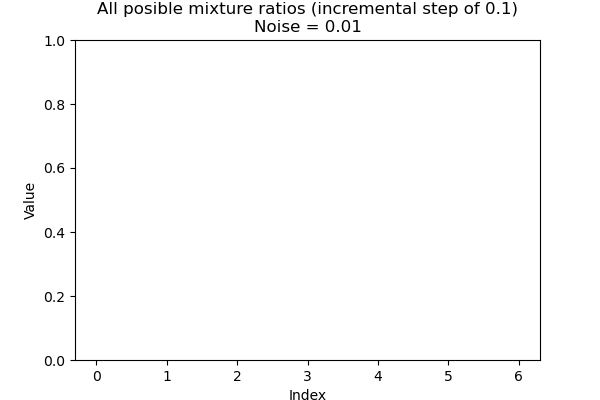

In [8]:
noise_perc = 0.01
dataset_noise01 = NoisyDataset(dataset, noise_perc)


# Assuming you have a PyTorch dataset named 'dataset'

x_values = []
y_values = []

for data in dataset_noise01:
    x, y = data  # Assuming each data point in the dataset consists of (x, y) pair
    x_values.append(x)
    y_values.append(y)


import matplotlib.pyplot as plt
import numpy as np


# Create a single plot
plt.figure(figsize=(6, 4))
plt.subplots_adjust(top=0.9, bottom=0.1)

# Iterate over each x value and plot the specified indices
for x in x_values:
    plt.plot(np.arange(len(b_f_comb)), x)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('All posible mixture ratios (incremental step of 0.1)\n' + 'Noise = ' + str(noise_perc))
plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
# plt.legend(range(len(x_values)))
plt.ylim(0, 1)
plt.show()

plt.savefig('noise' + str(noise_perc) + '.png')

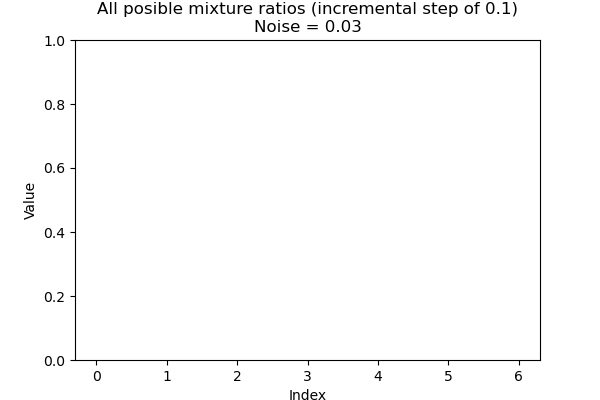

In [9]:
noise_perc = 0.03
dataset_noise01 = NoisyDataset(dataset, noise_perc)


# Assuming you have a PyTorch dataset named 'dataset'

x_values = []
y_values = []

for data in dataset_noise01:
    x, y = data  # Assuming each data point in the dataset consists of (x, y) pair
    x_values.append(x)
    y_values.append(y)


import matplotlib.pyplot as plt
import numpy as np


# Create a single plot
plt.figure(figsize=(6, 4))
plt.subplots_adjust(top=0.9, bottom=0.1)

# Iterate over each x value and plot the specified indices
for x in x_values:
    plt.plot(np.arange(len(b_f_comb)), x)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('All posible mixture ratios (incremental step of 0.1)\n' + 'Noise = ' + str(noise_perc))
plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
# plt.legend(range(len(x_values)))
plt.ylim(0, 1)
plt.show()

plt.savefig('noise' + str(noise_perc) + '.png')

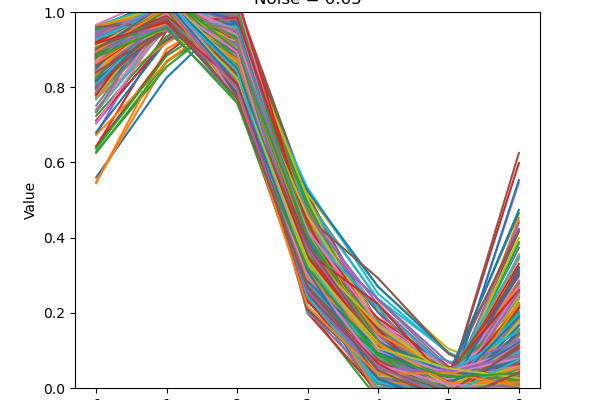

In [9]:
noise_perc = 0.05
dataset_noise01 = NoisyDataset(dataset, noise_perc)


# Assuming you have a PyTorch dataset named 'dataset'

x_values = []
y_values = []

for data in dataset_noise01:
    x, y = data  # Assuming each data point in the dataset consists of (x, y) pair
    x_values.append(x)
    y_values.append(y)


import matplotlib.pyplot as plt
import numpy as np


# Create a single plot
plt.figure(figsize=(6, 4))
plt.subplots_adjust(top=0.97, bottom=0.03)

# Iterate over each x value and plot the specified indices
for x in x_values:
    plt.plot(np.arange(len(b_f_comb)), x)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('All posible mixture ratios (incremental step of 0.1)\n' + 'Noise = ' + str(noise_perc))
plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
# plt.legend(range(len(x_values)))
plt.ylim(0, 1)
plt.show()

plt.savefig('noise' + str(noise_perc) + '.png')


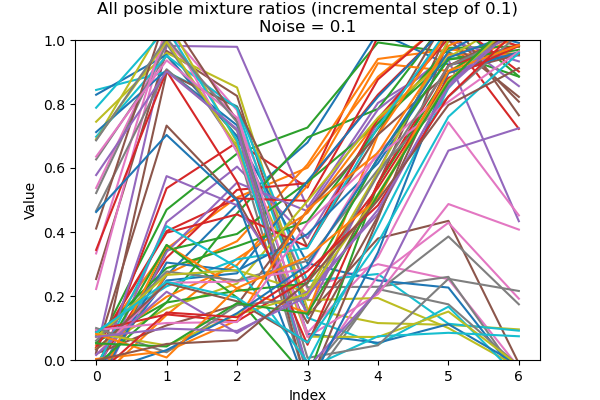

In [ ]:
noise_perc = 0.1
dataset_noise01 = NoisyDataset(dataset, noise_perc)


# Assuming you have a PyTorch dataset named 'dataset'

x_values = []
y_values = []

for data in dataset_noise01:
    x, y = data  # Assuming each data point in the dataset consists of (x, y) pair
    x_values.append(x)
    y_values.append(y)


import matplotlib.pyplot as plt
import numpy as np


# Create a single plot
plt.figure(figsize=(6, 4))
plt.subplots_adjust(top=0.9, bottom=0.1)

# Iterate over each x value and plot the specified indices
for x in x_values:
    plt.plot(np.arange(len(b_f_comb)), x)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('All posible mixture ratios (incremental step of 0.1)\n' + 'Noise = ' + str(noise_perc))
plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
# plt.legend(range(len(x_values)))
plt.ylim(0, 1)
plt.show()

plt.savefig('noise' + str(noise_perc) + '.png')


In [ ]:
from tools import difference_matrix

x_values = np.stack(x_values, axis=0)


diff_matrix = difference_matrix(x_values)

np.savetxt("diff_matrix.csv", diff_matrix, delimiter=",")

In [ ]:
y_values = np.stack(y_values, axis=0)

y_single_sub_perc = np.eye(len(substance_ind_list))

single_sub_index = []

for perc in y_single_sub_perc:
    print(perc)
    index = np.where((y_values == perc).all(axis=1))[0]
    print(index)
    single_sub_index.append(index[0])

single_sub_index.sort()
print(single_sub_index)

[1. 0. 0. 0.]
[285]
[0. 1. 0. 0.]
[65]
[0. 0. 1. 0.]
[10]
[0. 0. 0. 1.]
[0]
[0, 10, 65, 285]


In [ ]:
import numpy as np

# Assuming you have the difference matrix and single_sub_index values
diff_matrix = np.array(diff_matrix)  # Convert the difference matrix to a NumPy array
single_sub_index = np.array(single_sub_index)  # Convert single_sub_index to a NumPy array

closest_indices = []
num_closest = 10  # Number of closest indices to find

# Iterate over each single_sub_index value
for index in single_sub_index:
    # Get the row corresponding to the current index from the difference matrix
    row = diff_matrix[index]

    # Sort the row indices based on their values in ascending order
    sorted_indices = np.argsort(row)

    # Exclude the current index from the sorted indices
    sorted_indices = sorted_indices[sorted_indices != index]

    # Get the closest indices by taking the first num_closest values
    closest = sorted_indices[:num_closest]

    closest_indices.append(closest)

print("Closest Indices:")
for i, indices in enumerate(closest_indices):
    print(f"Index {single_sub_index[i]}: {indices}")


Closest Indices:
Index 0: [ 66 121 166   1 202  67 230  76  11 122]
Index 10: [109  19 162  75  42 104  56  47 118  36]
Index 65: [ 59  64 120  62 114 117  61  63  50 165]
Index 285: [282 276 267 231 236 252 256 277 266 283]


In [ ]:
import numpy as np

# Assuming you have the difference matrix and single_sub_index values
diff_matrix = np.array(diff_matrix)  # Convert the difference matrix to a NumPy array
single_sub_index = np.array(single_sub_index)  # Convert single_sub_index to a NumPy array

closest_indices = []
threshold = 0.2  # Threshold value

# Iterate over each single_sub_index value
for index in single_sub_index:
    # Get the row corresponding to the current index from the difference matrix
    row = diff_matrix[index]

    # Sort the row indices based on their values in ascending order
    sorted_indices = np.argsort(row)

    # Exclude the current index from the sorted indices
    sorted_indices = sorted_indices[sorted_indices != index]

    # Get the closest indices below the threshold
    closest = sorted_indices[row[sorted_indices] < threshold]

    closest_indices.append(closest)

print("Closest Indices:")
for i, indices in enumerate(closest_indices):
    print(f"Index {single_sub_index[i]}: {indices}")


Closest Indices:
Index 0: []
Index 10: []
Index 65: []
Index 285: []


mixture values[0]: [0. 0. 0. 1.]


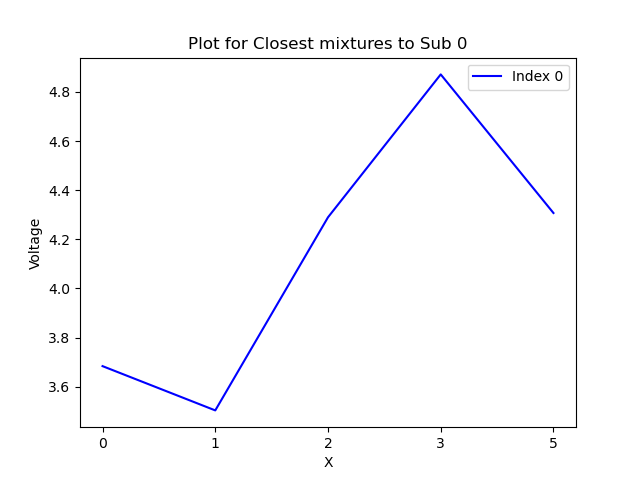

mixture values[10]: [0. 0. 1. 0.]


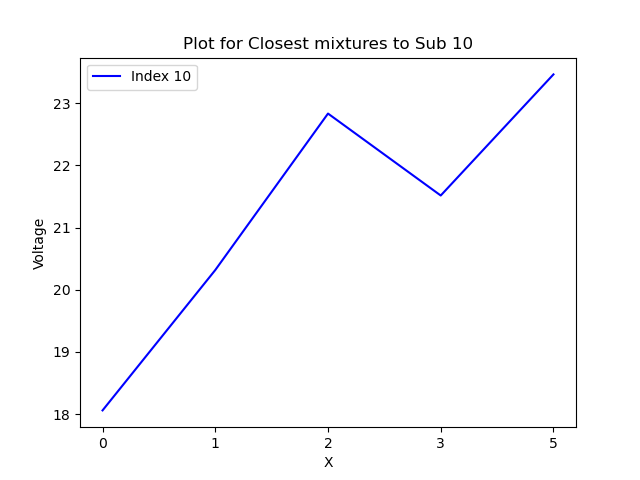

mixture values[65]: [0. 1. 0. 0.]


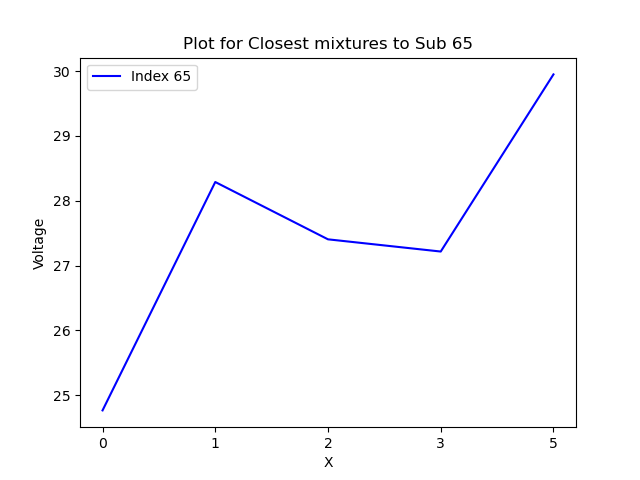

mixture values[285]: [1. 0. 0. 0.]


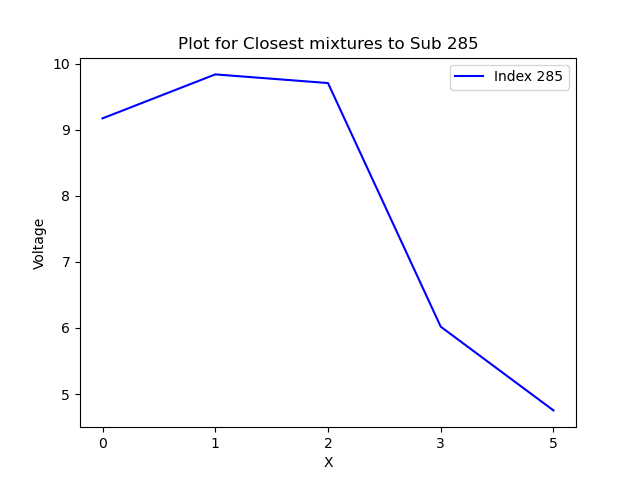

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have x_values, y_values, and closest_indices available

# Set the color for the main plot
main_color = 'blue'
sub_color = 'red'

# Create a separate plot for each index in single_sub_index
for i, index in enumerate(single_sub_index):
    # Create a new figure and axis for each plot
    plt.figure()

    # Plot x_values[index] with the main color
    plt.plot(x_values[index], color=main_color, label=f'Index {index}')

    # Plot x_values for the closest indices
    for closest_index in closest_indices[i]:
        plt.plot(x_values[closest_index], color=sub_color, label=f'Index {closest_index}')

#         # Calculate MSE between x_values[closest_index] and x_values[index]
#         mse = np.mean(np.square(x_values[closest_index] - x_values[index]))
#         print(f"MSE (Index {closest_index} to Index {index}): {mse}")
        
        # Calculate L1 distance between x_values[closest_index] and x_values[index]
        l1_distance = np.linalg.norm(x_values[closest_index] - x_values[index], ord=1)
        print(f"L1 Distance (Index {closest_index} to Index {index}): {l1_distance}")


    # Print y_values[index]
    print(f"mixture values[{index}]: {y_values[index]}")

    # Print y_values for the closest indices
    for closest_index in closest_indices[i]:
        print(f"mixture values[{closest_index}]: {y_values[closest_index]}")

    # Set the y-axis range to 0 to 30
#     plt.ylim(0, 30)

    # Add labels and legend to the plot
    plt.xlabel('X')
    plt.ylabel('Voltage')
    plt.xticks(np.arange(len(b_f_comb)), b_f_comb)
    plt.title(f"Plot for Closest mixtures to Sub {index}")
    plt.legend()
    

    # Show the plot
    plt.show()
